# Regional MOM6 NWA marine heatwave
- using the reforecast(hindcast) of regional mom6 to investigate the marine heatwave in NWA 
- the climatology period is set to 1993-2023 (30 years)

## Calculate Period Specific Climatology

In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client
from mom6.mom6_module import mom6_io
from mom6.mom6_module import mom6_statistics
from mom6.mom6_module import mom6_mhw

In [2]:
### open local cluster
client = Client(processes=False)
print(client)
print(client.cluster.dashboard_link)

<Client: 'inproc://10.173.16.4/2808999/1' processes=1 threads=96, memory=0.98 TiB>
http://10.173.16.4:37629/status


In [3]:
FORECAST = mom6_io.MOM6Forecast(
    var='tos',
    data_relative_dir='forecast/',
    static_relative_dir='static/',
    grid='raw',
    source='local')

In [4]:
ds_forecast = FORECAST.get_all()
ds_forecast = ds_forecast.rename({'geolon':'lon','geolat':'lat'})

In [5]:
class_forecast_climo = mom6_statistics.ForecastClimatology(ds_forecast,'tos')
da_climo = class_forecast_climo.generate_climo(1993,2022,'compute')

In [6]:
da_anom = ds_forecast['tos'].groupby('init.month')-da_climo
ds_anom = xr.Dataset()
ds_anom['tos'] = da_anom.persist()
# missing lon coord after subtraction
ds_anom['lon'] = da_climo.lon
ds_anom = ds_anom.set_coords('lon')

In [7]:
class_forecast_quantile = mom6_statistics.ForecastQuantile(ds_anom,'tos')
da_threshold = class_forecast_quantile.generate_quantile(1993,2022,90)

In [8]:
import importlib
from mom6.mom6_module import mom6_mhw
importlib.reload(mom6_mhw)

class_mhw = mom6_mhw.MarineHeatwaveForecast(ds_forecast,'tos')
ds_mhw_single = class_mhw.generate_forecast_single('2022-03',da_climo,da_threshold)

In [9]:
ds_mhw_single

<xarray.Dataset> Size: 382MB
Dimensions:                  (xh: 775, yh: 845, init: 1, lead: 12, member: 10)
Coordinates:
  * xh                       (xh) float64 6kB -98.0 -97.92 ... -36.16 -36.08
  * yh                       (yh) float64 7kB 5.273 5.352 5.432 ... 51.91 51.93
    lon                      (yh, xh) float32 3MB 262.0 262.1 ... 322.7 322.8
    lat                      (yh, xh) float32 3MB 5.273 5.273 ... 58.16 58.16
  * init                     (init) datetime64[ns] 8B 2022-03-01
  * lead                     (lead) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
    month                    (init) int32 4B 3
    quantile                 (init) float64 8B 0.9
  * member                   (member) int32 40B 1 2 3 4 5 6 7 8 9 10
Data variables:
    mhw_prob90               (init, lead, yh, xh) float32 31MB nan nan ... 0.3
    ssta_avg                 (init, lead, yh, xh) float32 31MB nan ... 0.2155
    mhw_mag_indentified_ens  (init, member, lead, yh, xh) float32 314MB nan ....
Attributes:
    period_of_quantile:     The 90 quantile from year 1993 to 2022
    period_of_climatology:  year 1993 to 2022

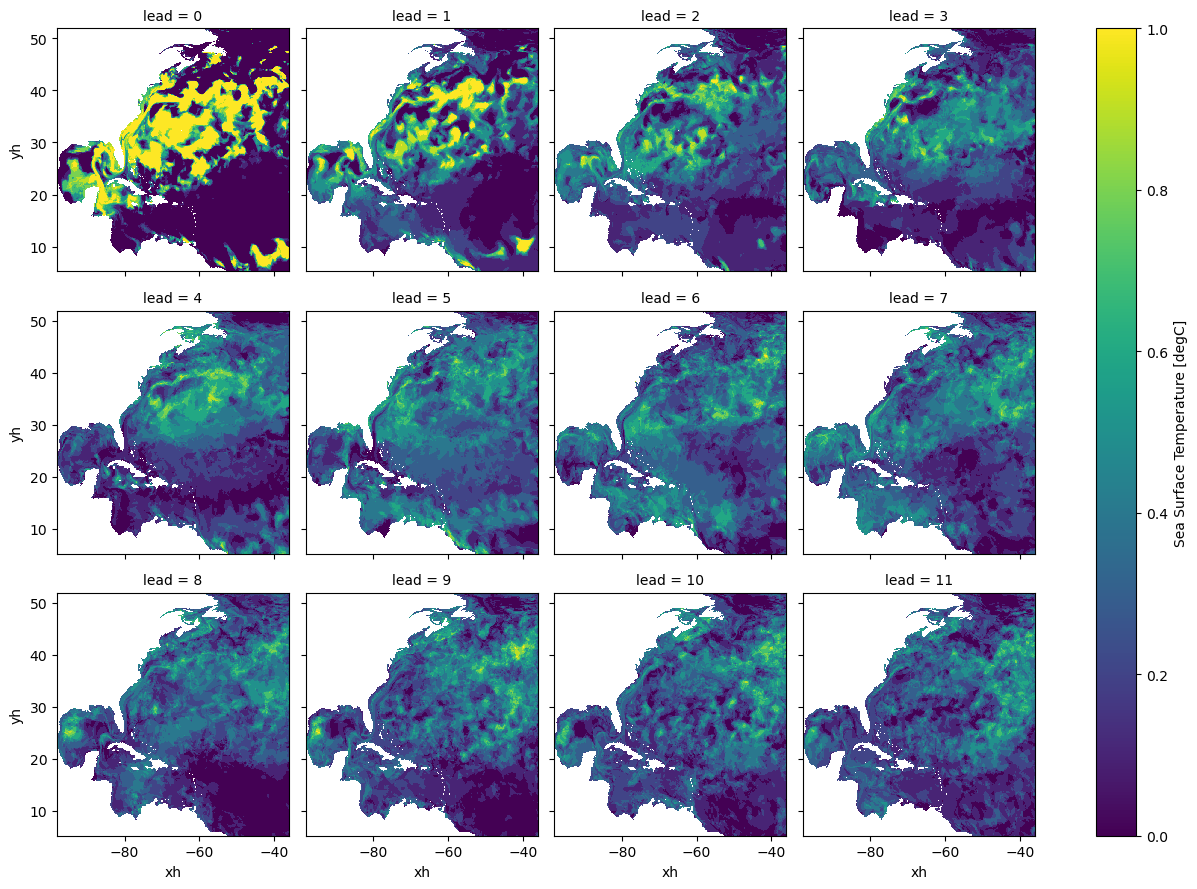

In [10]:
ds_mhw_single.mhw_prob90.isel(init=0).plot(col='lead',col_wrap=4)

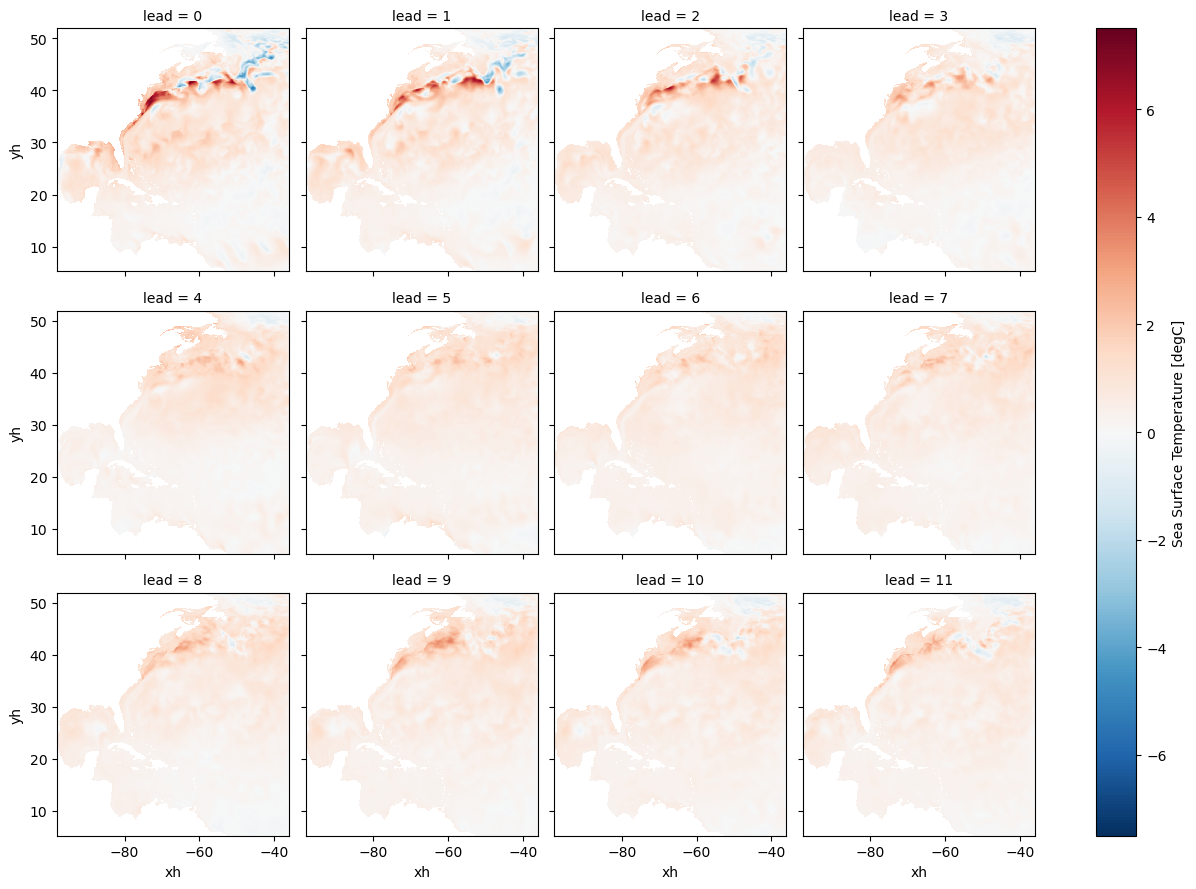

In [11]:
ds_mhw_single.ssta_avg.isel(init=0).plot(col='lead',col_wrap=4)

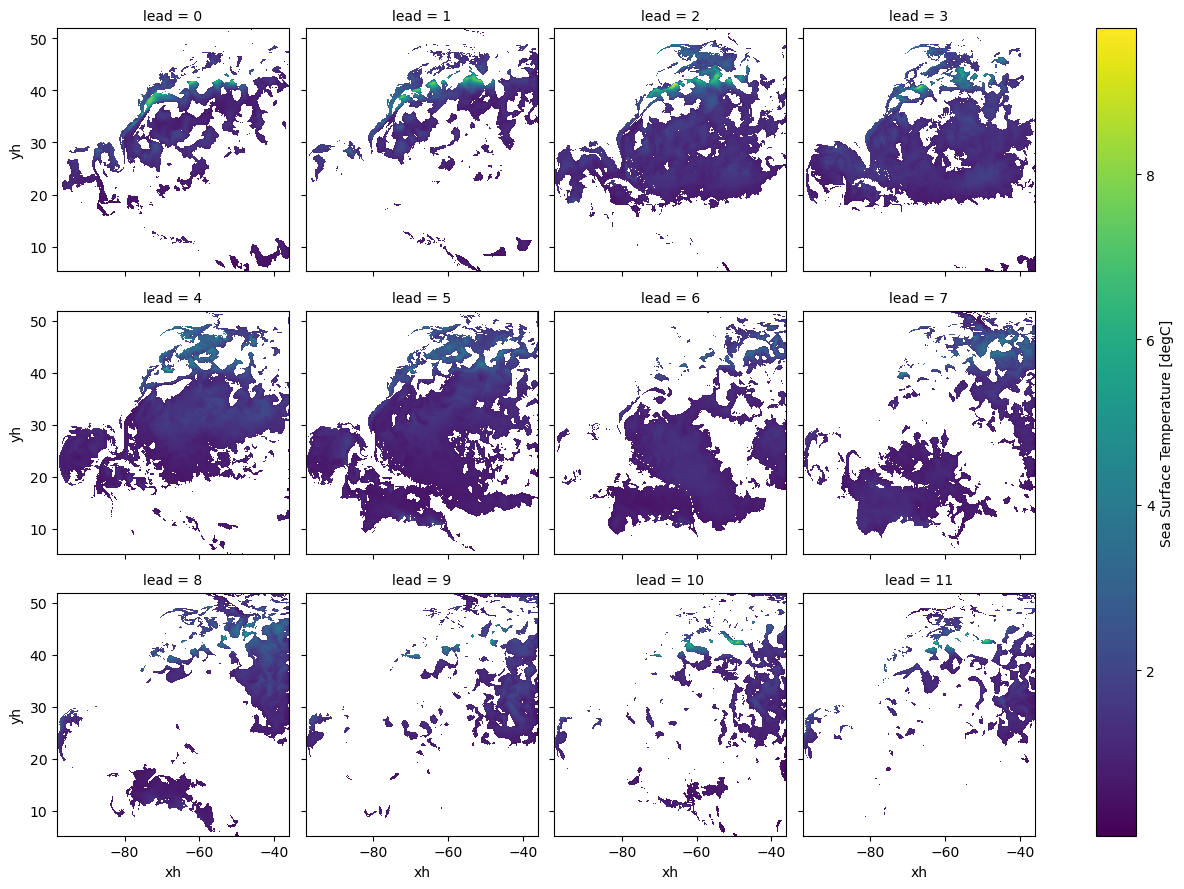

In [12]:
ds_mhw_single.mhw_mag_indentified_ens.isel(init=0,member=0).plot(col='lead',col_wrap=4)

In [13]:
import importlib
from mom6.mom6_module import mom6_statistics
from mom6.mom6_module import mom6_mhw
importlib.reload(mom6_mhw)
importlib.reload(mom6_statistics)

class_mhw = mom6_mhw.MarineHeatwaveForecast(ds_forecast,'tos')
ds_mhw_batch = class_mhw.generate_forecast_batch(1993,2022,1993,2022,90)

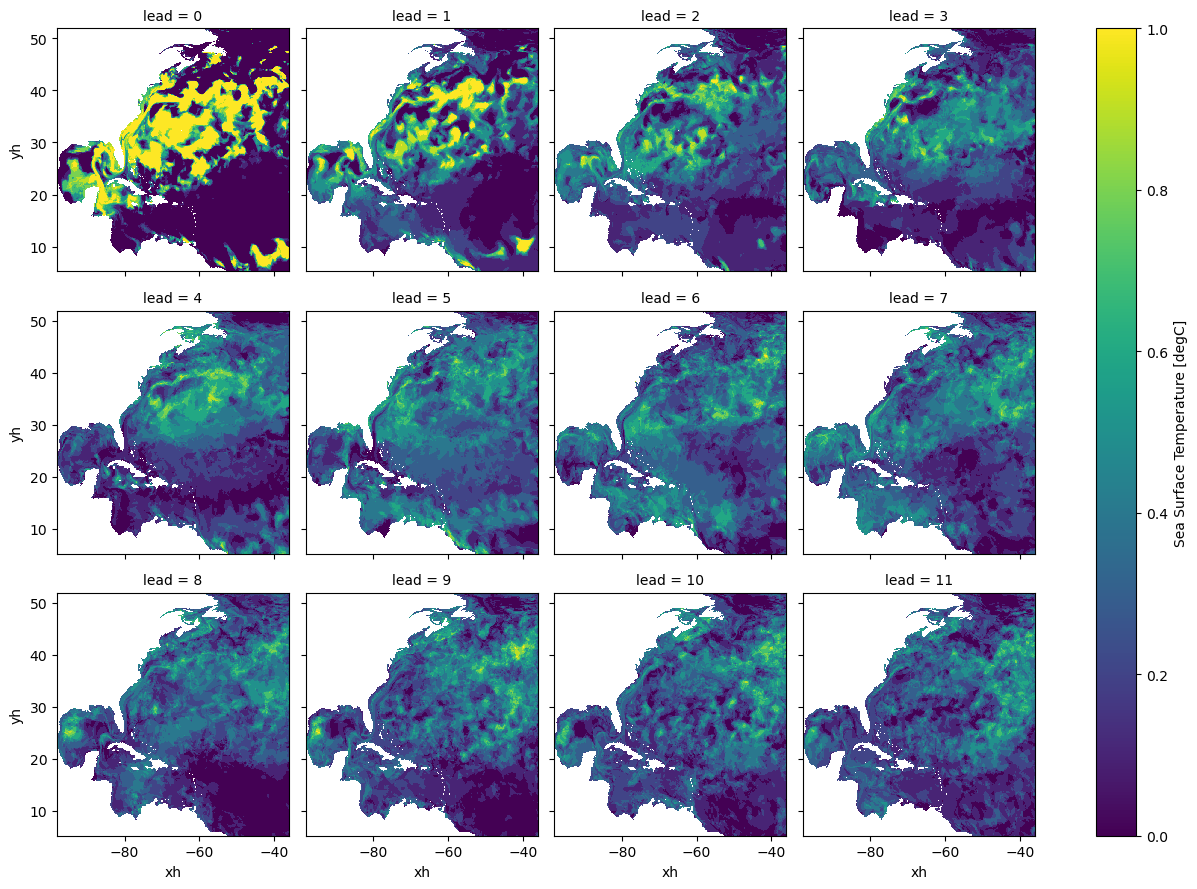

In [14]:
ds_mhw_batch.mhw_prob90.isel(init=-4).plot(col='lead',col_wrap=4)